In [1]:
import jax
import jax.numpy as jnp
import discovery as ds
import eryn
import glob

from discoverysamplers.gpry_interface import DiscoveryGPryCobayaBridge

In [2]:
allpsrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob('../data/NanoGrav_15yr/*-[JB]*.feather'))]

print(f"Loaded {len(allpsrs)} pulsars from feather files.")

psrs = allpsrs[:3]

print("Building likelihood for 3 pulsars...")

m = ds.ArrayLikelihood([ds.PulsarLikelihood([psr.residuals,
                                        ds.makenoise_measurement(psr, psr.noisedict),
                                        ds.makegp_ecorr(psr, psr.noisedict),
                                        ds.makegp_timing(psr, svd=True),
                                        ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')])
                for psr in psrs])
print("...done.")

Loaded 67 pulsars from feather files.
Building likelihood for 3 pulsars...
...done.


In [3]:

m.logL.params

['B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A']

In [4]:
# Make Latex labels for parameters
latex_labels = {}
for param in m.logL.params:
    if 'log10_A' in param:
        pulsar_name = param.split('_rednoise_')[0]
        latex_labels[param] = r"$\log_{10} A_{" + pulsar_name + r"}$"
    elif 'gamma' in param:
        pulsar_name = param.split('_rednoise_')[0]
        latex_labels[param] = r"$\gamma_{" + pulsar_name + r"}$"
    else:
        latex_labels[param] = param
print(latex_labels)

{'B1855+09_rednoise_gamma': '$\\gamma_{B1855+09}$', 'B1855+09_rednoise_log10_A': '$\\log_{10} A_{B1855+09}$', 'B1937+21_rednoise_gamma': '$\\gamma_{B1937+21}$', 'B1937+21_rednoise_log10_A': '$\\log_{10} A_{B1937+21}$', 'B1953+29_rednoise_gamma': '$\\gamma_{B1953+29}$', 'B1953+29_rednoise_log10_A': '$\\log_{10} A_{B1953+29}$'}


In [5]:
p0 = ds.sample_uniform(m.logL.params, n=1)
print(p0)
m.logL(p0)

{'B1855+09_rednoise_gamma': 4.479376778386527, 'B1855+09_rednoise_log10_A': -15.262530200850572, 'B1937+21_rednoise_gamma': 3.4286855659770388, 'B1937+21_rednoise_log10_A': -12.35924868664541, 'B1953+29_rednoise_gamma': 3.6136069345485566, 'B1953+29_rednoise_log10_A': -15.096770034593579}


Array(473743.97465675, dtype=float64)

In [6]:

test_priors = {
    'B1855+09_rednoise_gamma': {'dist': 'uniform', 'min': 0, 'max': 7},
    'B1855+09_rednoise_log10_A': {'dist': 'uniform', 'min': -20, 'max': -11},
    'B1937+21_rednoise_gamma': {'dist': 'uniform', 'min': 0, 'max': 7},
    'B1937+21_rednoise_log10_A': {'dist': 'fixed', 'value': -13.5},
    'B1953+29_rednoise_gamma': {'dist': 'fixed', 'value': 3},
    'B1953+29_rednoise_log10_A': {'dist': 'uniform', 'min': -20, 'max': -11},
}
alternative_paramnames = {
    'B1855+09_rednoise_gamma': 'gamma_1855',
    'B1855+09_rednoise_log10_A': 'log10_A_1855',
    'B1937+21_rednoise_gamma': 'gamma_1937',
    'B1937+21_rednoise_log10_A': 'log10_A_1937',
    'B1953+29_rednoise_gamma': 'gamma_1953',
    'B1953+29_rednoise_log10_A': 'log10_A_1953',
}

In [15]:
bridge = DiscoveryGPryCobayaBridge(m, 
                                   priors=test_priors, 
                                   latex_labels=latex_labels, 
                                   alternative_paramnames=alternative_paramnames,
                                   runner_kwargs={
                                       "options": {"n_initial": 50},
                                       "load_checkpoint": "overwrite",
                                       "surrogate": {"regressor": {"noise_level": 1e0}},
                                       "gp_acquisition": "NORA",
                                       "plots": True
                                   })

{'gamma_1855': 'B1855+09_rednoise_gamma', 'log10_A_1855': 'B1855+09_rednoise_log10_A', 'gamma_1937': 'B1937+21_rednoise_gamma', 'log10_A_1937': 'B1937+21_rednoise_log10_A', 'gamma_1953': 'B1953+29_rednoise_gamma', 'log10_A_1953': 'B1953+29_rednoise_log10_A'}
All names: ('gamma_1855', 'log10_A_1855', 'gamma_1937', 'log10_A_1937', 'gamma_1953', 'log10_A_1953')
[discovery_like] Initialized external likelihood.


In [16]:
print(bridge.sampled_names)
print(bridge.fixed_names)


['gamma_1855', 'log10_A_1855', 'gamma_1937', 'log10_A_1953']
['log10_A_1937', 'gamma_1953']


In [17]:
print(bridge.model.prior.sample(1000))

[[  1.38638344 -16.68584803   0.26162103 -11.64000695]
 [  4.41777582 -17.62848514   0.0203705  -18.56322579]
 [  6.54086518 -17.38643188   4.48898737 -14.09866462]
 ...
 [  4.87318281 -11.06545719   0.79294455 -15.50895779]
 [  4.40027157 -14.24300689   5.51176618 -17.28211213]
 [  1.72246313 -15.6790662    2.53694644 -14.0464675 ]]


In [18]:
sampler = bridge.run(checkpoint="gpry_test")

Successfully created the directory gpry_test/images
Initializing SurrogateModel with the following options:
* X-preprocessor: NormalizeBounds
* y-preprocessor: NormalizeY
* GPR kernel:
   3.16**2 * RBF(length_scale=[0.1, 0.1, 0.1, 0.1])
  with hyperparameters (in transformed scale):
    -Hyperparameter(name='k1__constant_value', value_type='numeric', bounds=array([[1.e-04, 1.e+06]]), max_length=None, n_elements=1, fixed=False, dynamic=False)
    -Hyperparameter(name='k2__length_scale', value_type='numeric', bounds=array([[1.e-05, 1.e+05],
       [1.e-05, 1.e+05],
       [1.e-05, 1.e+05],
       [1.e-05, 1.e+05]]), max_length=None, n_elements=4, fixed=False, dynamic=False)
* Noise level: 1.0
* Classifiers for infinities: SVM (threshold: 20s)
[ACQUISITION : NORA] Importing the default NS PolyChord failed (Err msg: External nested sampler Polychord cannot be imported. Check out installation instructions at https://github.com/PolyChord/PolyChordLite (or select an alternative nested sampler

60it [00:00, 782.53it/s]              

[EVALUATION] (0.077 sec) Evaluated the true log-posterior at 100 location(s), of which 60 returned a finite value.


[FIT] (0.19 sec) Fitted GP model with new acquired points, including the surrogate model hyperparameters. 60 finite points were added to the GP regressor.
| Iteration 1 (at most 115 left)                                              |
| Total truth evals: 100 (60 finite) of 560                                   |
[ultranest] Sampling 100 live points from prior ...
[ultranest] Sampling 100 live points from prior ...
[ultranest] Widening roots to 130 live points (have 100 already) ...
[ultranest] Widening roots to 130 live points (have 100 already) ...
[ultranest] Sampling 30 live points from prior ...
[ultranest] Sampling 30 live points from prior ...
[ultranest] Widening roots to 168 live points (have 130 already) ...
[ultranest] Widening roots to 168 live points (have 130 already) ...
[ultranest] Sampling 38 live points from prior ...
[ultranest] Sampling 38 live points from prior ...


/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


[ultranest] Explored until L=5e+05  
[ultranest] Explored until L=5e+05  
[ultranest] Likelihood function evaluations: 53446
[ultranest] Likelihood function evaluations: 53446
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = 4.739e+05 +- 0.2259
[ultranest]   logZ = 4.739e+05 +- 0.2259
[ultranest] Effective samples strategy wants to improve: 473855.02..473863.05 (ESS = 388.5, need >400)
[ultranest] Effective samples strategy wants to improve: 473855.02..473863.05 (ESS = 388.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.19 nat, need <0.50 nat)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.19 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 98 minimum live points (dlogz from 0.18 to 0.50, need <0.5)
[ultranest] Evidency unc

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


| Iteration 6 (at most 110 left)                                              |
| Total truth evals: 120 (77 finite) of 560                                   |
[ACQUISITION : NORA] (0.0027 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.0045 sec) Ranked pool of candidates.
[ACQUISITION] (0.0075 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.0074 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.0025 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473879.96317285625
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.00084 sec) Evaluated convergence criterion: 
[CONVERGENCE] [=============|·········] CorrectCounter [s]: 61 (limit 1.7)
[CONVERGENCE] [=======================> GaussianKL [s]: 0.0011 (limit 0.02)
[CONVERGENCE] [====

/Users/jeg/Documents/GPry-test-version/GPry/gpry/run.py:1153: RuntimeWarning: divide by zero encountered in log10
  value = np.log10(cc.last_value)


| Iteration 9 (at most 107 left)                                              |
| Total truth evals: 132 (88 finite) of 560                                   |
[ultranest] Sampling 100 live points from prior ...
[ultranest] Sampling 100 live points from prior ...
[ultranest] Widening roots to 130 live points (have 100 already) ...
[ultranest] Widening roots to 130 live points (have 100 already) ...
[ultranest] Sampling 30 live points from prior ...
[ultranest] Sampling 30 live points from prior ...
[ultranest] Widening roots to 168 live points (have 130 already) ...
[ultranest] Widening roots to 168 live points (have 130 already) ...
[ultranest] Sampling 38 live points from prior ...
[ultranest] Sampling 38 live points from prior ...
[ultranest] Explored until L=5e+05  
[ultranest] Explored until L=5e+05  
[ultranest] Likelihood function evaluations: 168
[ultranest] Likelihood function evaluations: 168
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and 

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


| Iteration 10 (at most 106 left)                                             |
| Total truth evals: 136 (92 finite) of 560                                   |
[ACQUISITION : NORA] (0.0056 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.0048 sec) Ranked pool of candidates.
[ACQUISITION] (0.011 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.0073 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.0017 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473879.96317285625
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.0015 sec) Evaluated convergence criterion: 
[CONVERGENCE] [==========|············] CorrectCounter [s]: 59 (limit 0.5)
[CONVERGENCE] [=|·····················] GaussianKL [s]: 95 (limit 0.02)
[CONVERGENCE] <··········

/Users/jeg/Documents/GPry-test-version/GPry/gpry/convergence.py:754: RuntimeWarning: invalid value encountered in sqrt
  return credibility_of_nstd(np.sqrt(chi2), len(mean1))


| Iteration 11 (at most 105 left)                                             |
| Total truth evals: 140 (95 finite) of 560                                   |
[ACQUISITION : NORA] (0.0024 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.0018 sec) Ranked pool of candidates.
[ACQUISITION] (0.0044 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.0098 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.001 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 18 restart(s) per MPI process..
Current maximum log-posterior: 473879.96317285625
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.00083 sec) Evaluated convergence criterion: 
[CONVERGENCE] [==========|············] CorrectCounter [s]: 63 (limit 0.46)
[CONVERGENCE] <·······················] GaussianKL [s]: nan (limit 0.02)
[CONVERGENCE] <······

/Users/jeg/Documents/GPry-test-version/GPry/gpry/convergence.py:754: RuntimeWarning: invalid value encountered in sqrt
  return credibility_of_nstd(np.sqrt(chi2), len(mean1))


| Iteration 12 (at most 104 left)                                             |
| Total truth evals: 144 (99 finite) of 560                                   |
[ACQUISITION : NORA] (0.0064 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.003 sec) Ranked pool of candidates.
[ACQUISITION] (0.0098 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.012 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.0028 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473879.96317285625
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.00069 sec) Evaluated convergence criterion: 
[CONVERGENCE] [==========|············] CorrectCounter [s]: 62 (limit 0.47)
[CONVERGENCE] <·······················] GaussianKL [s]: nan (limit 0.02)
[CONVERGENCE] <········

/Users/jeg/Documents/GPry-test-version/GPry/gpry/convergence.py:754: RuntimeWarning: invalid value encountered in sqrt
  return credibility_of_nstd(np.sqrt(chi2), len(mean1))


| Iteration 13 (at most 103 left)                                             |
| Total truth evals: 148 (103 finite) of 560                                  |
[ultranest] Sampling 100 live points from prior ...
[ultranest] Sampling 100 live points from prior ...
[ultranest] Widening roots to 129 live points (have 100 already) ...
[ultranest] Widening roots to 129 live points (have 100 already) ...
[ultranest] Sampling 29 live points from prior ...
[ultranest] Sampling 29 live points from prior ...
[ultranest] Widening roots to 167 live points (have 129 already) ...
[ultranest] Widening roots to 167 live points (have 129 already) ...
[ultranest] Sampling 38 live points from prior ...
[ultranest] Sampling 38 live points from prior ...
[ultranest] Explored until L=5e+05  
[ultranest] Explored until L=5e+05  
[ultranest] Likelihood function evaluations: 167
[ultranest] Likelihood function evaluations: 167
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and 

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


| Iteration 14 (at most 102 left)                                             |
| Total truth evals: 152 (107 finite) of 560                                  |
[ACQUISITION : NORA] (0.001 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.0019 sec) Ranked pool of candidates.
[ACQUISITION] (0.0031 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.0074 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.00096 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473879.96317285625
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.00038 sec) Evaluated convergence criterion: 
[CONVERGENCE] [=========|·············] CorrectCounter [s]: 71 (limit 0.38)
[CONVERGENCE] <·······················] GaussianKL [s]: nan (limit 0.02)
[CONVERGENCE] [======

/Users/jeg/Documents/GPry-test-version/GPry/gpry/run.py:1153: RuntimeWarning: divide by zero encountered in log10
  value = np.log10(cc.last_value)


| Iteration 16 (at most 100 left)                                             |
| Total truth evals: 160 (115 finite) of 560                                  |
[ACQUISITION : NORA] (0.0035 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.0046 sec) Ranked pool of candidates.
[ACQUISITION] (0.0084 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.009 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.0081 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473879.96317285625
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.00041 sec) Evaluated convergence criterion: 
[CONVERGENCE] [==========|············] CorrectCounter [s]: 65 (limit 0.44)
[CONVERGENCE] <·······················] GaussianKL [s]: 0 (limit 0.02)
[CONVERGENCE] [=========

/Users/jeg/Documents/GPry-test-version/GPry/gpry/run.py:1153: RuntimeWarning: divide by zero encountered in log10
  value = np.log10(cc.last_value)


| Iteration 17 (at most 99 left)                                              |
| Total truth evals: 164 (119 finite) of 560                                  |
[ultranest] Sampling 100 live points from prior ...
[ultranest] Sampling 100 live points from prior ...
[ultranest] Widening roots to 133 live points (have 100 already) ...
[ultranest] Widening roots to 133 live points (have 100 already) ...
[ultranest] Sampling 33 live points from prior ...
[ultranest] Sampling 33 live points from prior ...
[ultranest] Widening roots to 179 live points (have 133 already) ...
[ultranest] Widening roots to 179 live points (have 133 already) ...
[ultranest] Sampling 46 live points from prior ...
[ultranest] Sampling 46 live points from prior ...
[ultranest] Explored until L=5e+05  
[ultranest] Explored until L=5e+05  
[ultranest] Likelihood function evaluations: 179
[ultranest] Likelihood function evaluations: 179
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and 

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


| Iteration 18 (at most 98 left)                                              |
| Total truth evals: 168 (123 finite) of 560                                  |
[ACQUISITION : NORA] (0.0024 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.002 sec) Ranked pool of candidates.
[ACQUISITION] (0.0046 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.0069 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.011 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473879.96317285625
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.00045 sec) Evaluated convergence criterion: 
[CONVERGENCE] [===============|·······] CorrectCounter [s]: 15 (limit 0.95)
[CONVERGENCE] [=======================> GaussianKL [s]: 0.00035 (limit 0.02)
[CONVERGENCE] [====

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


| Iteration 22 (at most 94 left)                                              |
| Total truth evals: 184 (139 finite) of 560                                  |
[ACQUISITION : NORA] (0.0088 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.0023 sec) Ranked pool of candidates.
[ACQUISITION] (0.012 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.029 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.0024 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473879.96317285625
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.001 sec) Evaluated convergence criterion: 
[CONVERGENCE] [============|··········] CorrectCounter [s]: 1.1e+02 (limit 2.2)
[CONVERGENCE] <·······················] GaussianKL [s]: nan (limit 0.02)
[CONVERGENCE] [======

/Users/jeg/Documents/GPry-test-version/GPry/gpry/run.py:1153: RuntimeWarning: divide by zero encountered in log10
  value = np.log10(cc.last_value)


| Iteration 25 (at most 91 left)                                              |
| Total truth evals: 196 (150 finite) of 560                                  |
[ultranest] Sampling 100 live points from prior ...
[ultranest] Sampling 100 live points from prior ...
[ultranest] Widening roots to 135 live points (have 100 already) ...
[ultranest] Widening roots to 135 live points (have 100 already) ...
[ultranest] Sampling 35 live points from prior ...
[ultranest] Sampling 35 live points from prior ...
[ultranest] Widening roots to 179 live points (have 135 already) ...
[ultranest] Widening roots to 179 live points (have 135 already) ...
[ultranest] Sampling 44 live points from prior ...
[ultranest] Sampling 44 live points from prior ...
[ultranest] Explored until L=5e+05  
[ultranest] Explored until L=5e+05  
[ultranest] Likelihood function evaluations: 179
[ultranest] Likelihood function evaluations: 179
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and 

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


| Iteration 26 (at most 90 left)                                              |
| Total truth evals: 200 (152 finite) of 560                                  |
[ACQUISITION : NORA] (0.0025 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.0024 sec) Ranked pool of candidates.
[ACQUISITION] (0.0051 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.0078 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.0023 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473887.4121308082
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.0032 sec) Evaluated convergence criterion: 
[CONVERGENCE] [=============|·········] CorrectCounter [s]: 55 (limit 1.7)
[CONVERGENCE] |·······················] GaussianKL [s]: 2e+02 (limit 0.02)
[CONVERGENCE] [=======

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


| Iteration 30 (at most 86 left)                                              |
| Total truth evals: 216 (165 finite) of 560                                  |
[ACQUISITION : NORA] (0.0059 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.0073 sec) Ranked pool of candidates.
[ACQUISITION] (0.014 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.0097 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.0038 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473887.4121308082
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.0014 sec) Evaluated convergence criterion: 
[CONVERGENCE] [===============|·······] CorrectCounter [s]: 27 (limit 1.4)
[CONVERGENCE] [=|·····················] GaussianKL [s]: 99 (limit 0.02)
[CONVERGENCE] [===========

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


[PLOTS] Creating and saving progress plots...
| Iteration 34 (at most 82 left)                                              |
| Total truth evals: 232 (181 finite) of 560                                  |
[ACQUISITION : NORA] (0.0015 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.0024 sec) Ranked pool of candidates.
[ACQUISITION] (0.0041 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.006 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.0028 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473887.4121308082
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.00041 sec) Evaluated convergence criterion: 
[CONVERGENCE] [=======|···············] CorrectCounter [s]: 95 (limit 0.22)
[CONVERGENCE] [=======================> GaussianKL

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


[PLOTS] Creating and saving progress plots...
| Iteration 38 (at most 78 left)                                              |
| Total truth evals: 248 (197 finite) of 560                                  |
[ACQUISITION : NORA] (0.0063 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.0026 sec) Ranked pool of candidates.
[ACQUISITION] (0.0091 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.0069 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.0025 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473887.4121308082
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.00086 sec) Evaluated convergence criterion: 
[CONVERGENCE] [============|··········] CorrectCounter [s]: 45 (limit 0.72)
[CONVERGENCE] [=======================> GaussianK

/Users/jeg/Documents/GPry-test-version/GPry/gpry/run.py:1153: RuntimeWarning: divide by zero encountered in log10
  value = np.log10(cc.last_value)


| Iteration 40 (at most 76 left)                                              |
| Total truth evals: 256 (205 finite) of 560                                  |
[ACQUISITION : NORA] (0.0059 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.0093 sec) Ranked pool of candidates.
[ACQUISITION] (0.016 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.01 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.0027 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473887.4121308082
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.00092 sec) Evaluated convergence criterion: 
[CONVERGENCE] [=============|·········] CorrectCounter [s]: 58 (limit 1.7)
[CONVERGENCE] <·······················] GaussianKL [s]: 0 (limit 0.02)
[CONVERGENCE] [=============

/Users/jeg/Documents/GPry-test-version/GPry/gpry/run.py:1153: RuntimeWarning: divide by zero encountered in log10
  value = np.log10(cc.last_value)


| Iteration 41 (at most 75 left)                                              |
| Total truth evals: 260 (209 finite) of 560                                  |
[ultranest] Sampling 100 live points from prior ...
[ultranest] Sampling 100 live points from prior ...
[ultranest] Widening roots to 132 live points (have 100 already) ...
[ultranest] Widening roots to 132 live points (have 100 already) ...
[ultranest] Sampling 32 live points from prior ...
[ultranest] Sampling 32 live points from prior ...
[ultranest] Widening roots to 174 live points (have 132 already) ...
[ultranest] Widening roots to 174 live points (have 132 already) ...
[ultranest] Sampling 42 live points from prior ...
[ultranest] Sampling 42 live points from prior ...
[ultranest] Explored until L=5e+05  
[ultranest] Explored until L=5e+05  
[ultranest] Likelihood function evaluations: 174
[ultranest] Likelihood function evaluations: 174
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and 

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


| Iteration 42 (at most 74 left)                                              |
| Total truth evals: 264 (213 finite) of 560                                  |
[ACQUISITION : NORA] (0.0047 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.0028 sec) Ranked pool of candidates.
[ACQUISITION] (0.0077 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.025 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.0029 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473887.4121308082
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.00095 sec) Evaluated convergence criterion: 
[CONVERGENCE] [==========|············] CorrectCounter [s]: 67 (limit 0.5)
[CONVERGENCE] <·······················] GaussianKL [s]: nan (limit 0.02)
[CONVERGENCE] [=========

/Users/jeg/Documents/GPry-test-version/GPry/gpry/run.py:1153: RuntimeWarning: divide by zero encountered in log10
  value = np.log10(cc.last_value)


| Iteration 45 (at most 71 left)                                              |
| Total truth evals: 276 (224 finite) of 560                                  |
[ultranest] Sampling 100 live points from prior ...
[ultranest] Sampling 100 live points from prior ...
[ultranest] Widening roots to 129 live points (have 100 already) ...
[ultranest] Widening roots to 129 live points (have 100 already) ...
[ultranest] Sampling 29 live points from prior ...
[ultranest] Sampling 29 live points from prior ...
[ultranest] Widening roots to 172 live points (have 129 already) ...
[ultranest] Widening roots to 172 live points (have 129 already) ...
[ultranest] Sampling 43 live points from prior ...
[ultranest] Sampling 43 live points from prior ...
[ultranest] Explored until L=5e+05  
[ultranest] Explored until L=5e+05  
[ultranest] Likelihood function evaluations: 172
[ultranest] Likelihood function evaluations: 172
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and 

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


[PLOTS] Creating and saving progress plots...
| Iteration 46 (at most 70 left)                                              |
| Total truth evals: 280 (228 finite) of 560                                  |
[ACQUISITION : NORA] (0.0092 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.0046 sec) Ranked pool of candidates.
[ACQUISITION] (0.014 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.029 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.0016 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473887.4121308082
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.00048 sec) Evaluated convergence criterion: 
[CONVERGENCE] [===========|···········] CorrectCounter [s]: 7.4e+02 (limit 8.6)
[CONVERGENCE] [=======================> Gaussia

/Users/jeg/Documents/GPry-test-version/GPry/gpry/run.py:1153: RuntimeWarning: divide by zero encountered in log10
  value = np.log10(cc.last_value)


| Iteration 49 (at most 67 left)                                              |
| Total truth evals: 292 (239 finite) of 560                                  |
[ultranest] Sampling 100 live points from prior ...
[ultranest] Sampling 100 live points from prior ...
[ultranest] Widening roots to 146 live points (have 100 already) ...
[ultranest] Widening roots to 146 live points (have 100 already) ...
[ultranest] Sampling 46 live points from prior ...
[ultranest] Sampling 46 live points from prior ...
[ultranest] Widening roots to 208 live points (have 146 already) ...
[ultranest] Widening roots to 208 live points (have 146 already) ...
[ultranest] Sampling 62 live points from prior ...
[ultranest] Sampling 62 live points from prior ...
[ultranest] Explored until L=5e+05  
[ultranest] Explored until L=5e+05  
[ultranest] Likelihood function evaluations: 208
[ultranest] Likelihood function evaluations: 208
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and 

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


[PLOTS] Creating and saving progress plots...
| Iteration 50 (at most 66 left)                                              |
| Total truth evals: 296 (243 finite) of 560                                  |
[ACQUISITION : NORA] (0.0054 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.0028 sec) Ranked pool of candidates.
[ACQUISITION] (0.0084 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.014 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.0013 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473887.4121308082
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.00045 sec) Evaluated convergence criterion: 
[CONVERGENCE] [===========|···········] CorrectCounter [s]: 52 (limit 0.61)
[CONVERGENCE] [=======================> GaussianKL

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


[FIT] (0.0025 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473887.4121308082
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.00078 sec) Evaluated convergence criterion: 
[CONVERGENCE] [=========|·············] CorrectCounter [s]: 77 (limit 0.36)
[CONVERGENCE] [==================|····] GaussianKL [s]: 0.099 (limit 0.02)
[CONVERGENCE] [=======================> TrainAlignment [n]: 0.23 (limit 0.5)
[PLOTS] Creating and saving progress plots...
| Iteration 54 (at most 62 left)                                              |
| Total truth evals: 312 (257 finite) of 560                                  |
[ACQUISITION : NORA] (0.0026 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.003 sec) Ranked pool of candidates.
[ACQUISITION] (0.0058 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION

/Users/jeg/Documents/GPry-test-version/GPry/gpry/run.py:1153: RuntimeWarning: divide by zero encountered in log10
  value = np.log10(cc.last_value)


| Iteration 56 (at most 60 left)                                              |
| Total truth evals: 320 (264 finite) of 560                                  |
[ACQUISITION : NORA] (0.0016 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.0087 sec) Ranked pool of candidates.
[ACQUISITION] (0.011 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.0075 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.0027 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473887.4121308082
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.0011 sec) Evaluated convergence criterion: 
[CONVERGENCE] [===============|·······] CorrectCounter [s]: 26 (limit 1.4)
[CONVERGENCE] [=======================> GaussianKL [s]: 0.0032 (limit 0.02)
[CONVERGENCE] [=======

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


[ACQUISITION : NORA] (0.009 sec) Ranked pool of candidates.
[ACQUISITION] (0.2 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.0064 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.0029 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473887.4121308082
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.0041 sec) Evaluated convergence criterion: 
[CONVERGENCE] [==============|········] CorrectCounter [s]: 30 (limit 1.4)
[CONVERGENCE] [==================|····] GaussianKL [s]: 0.096 (limit 0.02)
[CONVERGENCE] [=======================> TrainAlignment [n]: 0.25 (limit 0.5)
[PLOTS] Creating and saving progress plots...
| Iteration 58 (at most 58 left)                                              |
| Total truth evals: 328 (272 finite) of 560     

/Users/jeg/Documents/GPry-test-version/GPry/gpry/run.py:1153: RuntimeWarning: divide by zero encountered in log10
  value = np.log10(cc.last_value)


| Iteration 61 (at most 55 left)                                              |
| Total truth evals: 340 (283 finite) of 560                                  |
[ultranest] Sampling 100 live points from prior ...
[ultranest] Sampling 100 live points from prior ...
[ultranest] Widening roots to 130 live points (have 100 already) ...
[ultranest] Widening roots to 130 live points (have 100 already) ...
[ultranest] Sampling 30 live points from prior ...
[ultranest] Sampling 30 live points from prior ...
[ultranest] Widening roots to 167 live points (have 130 already) ...
[ultranest] Widening roots to 167 live points (have 130 already) ...
[ultranest] Sampling 37 live points from prior ...
[ultranest] Sampling 37 live points from prior ...
[ultranest] Explored until L=5e+05  
[ultranest] Explored until L=5e+05  
[ultranest] Likelihood function evaluations: 167
[ultranest] Likelihood function evaluations: 167
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and 

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


[ACQUISITION : NORA] (0.2 sec) Obtained new MC sample with ultranest
[ACQUISITION : NORA] (0.0055 sec) Ranked pool of candidates.
[ACQUISITION] (0.21 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.0082 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.0031 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473887.4121308082
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.0009 sec) Evaluated convergence criterion: 
[CONVERGENCE] [==========|············] CorrectCounter [s]: 58 (limit 0.55)
[CONVERGENCE] [==================|····] GaussianKL [s]: 0.098 (limit 0.02)
[CONVERGENCE] [=======================> TrainAlignment [n]: 0.37 (limit 0.5)
[PLOTS] Creating and saving progress plots...
| Iteration 62 (at most 54 left)                         

/Users/jeg/Documents/GPry-test-version/GPry/gpry/run.py:1153: RuntimeWarning: divide by zero encountered in log10
  value = np.log10(cc.last_value)


| Iteration 64 (at most 52 left)                                              |
| Total truth evals: 352 (295 finite) of 560                                  |
[ACQUISITION : NORA] (0.0069 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.0095 sec) Ranked pool of candidates.
[ACQUISITION] (0.017 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.007 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.0029 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473887.4121308082
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.00092 sec) Evaluated convergence criterion: 
[CONVERGENCE] [========|··············] CorrectCounter [s]: 81 (limit 0.32)
[CONVERGENCE] <·······················] GaussianKL [s]: 0 (limit 0.02)
[CONVERGENCE] [===========

/Users/jeg/Documents/GPry-test-version/GPry/gpry/run.py:1153: RuntimeWarning: divide by zero encountered in log10
  value = np.log10(cc.last_value)


| Iteration 65 (at most 51 left)                                              |
| Total truth evals: 356 (297 finite) of 560                                  |
[ultranest] Sampling 100 live points from prior ...
[ultranest] Sampling 100 live points from prior ...
[ultranest] Widening roots to 138 live points (have 100 already) ...
[ultranest] Widening roots to 138 live points (have 100 already) ...
[ultranest] Sampling 38 live points from prior ...
[ultranest] Sampling 38 live points from prior ...
[ultranest] Widening roots to 192 live points (have 138 already) ...
[ultranest] Widening roots to 192 live points (have 138 already) ...
[ultranest] Sampling 54 live points from prior ...
[ultranest] Sampling 54 live points from prior ...
[ultranest] Explored until L=5e+05  
[ultranest] Explored until L=5e+05  
[ultranest] Likelihood function evaluations: 192
[ultranest] Likelihood function evaluations: 192
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and 

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


[PLOTS] Creating and saving progress plots...
| Iteration 66 (at most 50 left)                                              |
| Total truth evals: 360 (301 finite) of 560                                  |
[ACQUISITION : NORA] (0.0054 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.0032 sec) Ranked pool of candidates.
[ACQUISITION] (0.0088 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.0077 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.0041 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473887.4121308082
Current GPR kernel: 1**2 * RBF(length_scale=[8.15e+04, 1e-05, 1e-05, 1e-05])
[CONVERGENCE] (0.00088 sec) Evaluated convergence criterion: 
[CONVERGENCE] [==========|············] CorrectCounter [s]: 67 (limit 0.46)
[CONVERGENCE] <·······················] GaussianK

/Users/jeg/Documents/GPry-test-version/GPry/gpry/run.py:1153: RuntimeWarning: divide by zero encountered in log10
  value = np.log10(cc.last_value)


| Iteration 68 (at most 48 left)                                              |
| Total truth evals: 368 (309 finite) of 560                                  |
[ACQUISITION : NORA] (0.003 sec) Re-evaluated previous MC sample
[ACQUISITION : NORA] (0.004 sec) Ranked pool of candidates.
[ACQUISITION] (0.0072 sec) Proposed 4 point(s) for truth evaluation.
[EVALUATION] (0.0077 sec) Evaluated the true log-posterior at 4 location(s), of which 4 returned a finite value.
[FIT] (0.0031 sec) Fitted log(p) surrogate model with 4 new points, of which 4 were added to the GP regressor. Hyperparameters were fit with 1 restart(s) per MPI process..
Current maximum log-posterior: 473887.4121308082
Current GPR kernel: 1.11**2 * RBF(length_scale=[0.425, 0.124, 0.205, 0.168])
[CONVERGENCE] (0.00099 sec) Evaluated convergence criterion: 
[CONVERGENCE] [==============|········] CorrectCounter [s]: 10 (limit 0.4)
[CONVERGENCE] [=====|·················] GaussianKL [s]: 21 (limit 0.02)
[CONVERGENCE] [===========

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


[ultranest] Explored until L=5e+05  
[ultranest] Explored until L=5e+05  
[ultranest] Likelihood function evaluations: 5949
[ultranest] Likelihood function evaluations: 5949
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = 4.739e+05 +- 0.2797
[ultranest]   logZ = 4.739e+05 +- 0.2797
[ultranest] Effective samples strategy wants to improve: 473901.36..473907.93 (ESS = 274.6, need >400)
[ultranest] Effective samples strategy wants to improve: 473901.36..473907.93 (ESS = 274.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.15 nat, need <0.50 nat)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.15 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 98 minimum live points (dlogz from 0.22 to 0.71, need <0.5)
[ultranest] Evidency uncer

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


[ultranest] Explored until L=5e+05  
[ultranest] Explored until L=5e+05  
[ultranest] Likelihood function evaluations: 10016
[ultranest] Likelihood function evaluations: 10016
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = 4.739e+05 +- 0.2014
[ultranest]   logZ = 4.739e+05 +- 0.2014
[ultranest] Effective samples strategy satisfied (ESS = 577.8, need >400)
[ultranest] Effective samples strategy satisfied (ESS = 577.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.15 nat, need <0.50 nat)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.15 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.20, need <0.5)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.20, need <0.5)
[ultranest]   logZ error budget:

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


[ultranest] Explored until L=5e+05  
[ultranest] Explored until L=5e+05  
[ultranest] Likelihood function evaluations: 8697
[ultranest] Likelihood function evaluations: 8697
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = 4.739e+05 +- 0.2139
[ultranest]   logZ = 4.739e+05 +- 0.2139
[ultranest] Effective samples strategy satisfied (ESS = 552.3, need >400)
[ultranest] Effective samples strategy satisfied (ESS = 552.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.13 nat, need <0.50 nat)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.13 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.21, need <0.5)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.21, need <0.5)
[ultranest]   logZ error budget: s

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


[ultranest] Explored until L=5e+05  
[ultranest] Explored until L=5e+05  
[ultranest] Likelihood function evaluations: 7094
[ultranest] Likelihood function evaluations: 7094
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = 4.739e+05 +- 0.2358
[ultranest]   logZ = 4.739e+05 +- 0.2358
[ultranest] Effective samples strategy satisfied (ESS = 548.2, need >400)
[ultranest] Effective samples strategy satisfied (ESS = 548.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.17 nat, need <0.50 nat)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.17 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 98 minimum live points (dlogz from 0.19 to 0.56, need <0.5)
[ultranest] Evidency uncertainty strategy wants 98 minimum live points (dlogz from 0

/Users/jeg/Documents/GPry-test-version/GPry/gpry/gp_acquisition.py:857: UserWarning: Seeded runs are not supported for UltraNest.
  warnings.warn("Seeded runs are not supported for UltraNest.")


[ultranest] Explored until L=5e+05  
[ultranest] Explored until L=5e+05  
[ultranest] Likelihood function evaluations: 7664
[ultranest] Likelihood function evaluations: 7664
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = 4.739e+05 +- 0.1881
[ultranest]   logZ = 4.739e+05 +- 0.1881
[ultranest] Effective samples strategy satisfied (ESS = 553.8, need >400)
[ultranest] Effective samples strategy satisfied (ESS = 553.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.49+-0.15 nat, need <0.50 nat)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.49+-0.15 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.19, need <0.5)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.19, need <0.5)
[ultranest]   logZ error budget: s

/Users/jeg/Documents/GPry-test-version/GPry/gpry/mc.py:429: UserWarning: Importing the default NS PolyChord failed (Err msg: External nested sampler Polychord cannot be imported. Check out installation instructions at https://github.com/PolyChord/PolyChordLite (or select an alternative nested sampler, e.g. UltraNest).). Defaulting to UltraNest.
  warnings.warn(


[ultranest] Explored until L=5e+05  
[ultranest] Explored until L=5e+05  
[ultranest] Likelihood function evaluations: 11926
[ultranest] Likelihood function evaluations: 11926
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = 4.739e+05 +- 0.1402
[ultranest]   logZ = 4.739e+05 +- 0.1402
[ultranest] Effective samples strategy satisfied (ESS = 1072.0, need >400)
[ultranest] Effective samples strategy satisfied (ESS = 1072.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budge

In [20]:
bridge.runner.plot_mc()
samples_gpry = bridge.runner.last_mc_samples()

In [21]:
# Run nessai for comparison
from discoverysamplers.nessai_enterprise import DiscoveryNessaiBridge


bridge = DiscoveryNessaiBridge(m, priors=test_priors, latex_labels=latex_labels)
bridge.run_sampler(output='nessai_gpry_test')
samples_nessai = bridge.return_sampled_samples()

[glasflow] glasflow is using its own internal version of nflows
[nessai.model] pool and n_pool are none, no multiprocessing pool
[nessai.samplers.base] Initialising nested sampler
[nessai.model] *WARNING* Multiprocessing pool has already been configured.
[nessai.samplers.nestedsampler] Passing kwargs to FlowProposal: {'poolsize': 1000}
[nessai.proposal.flowproposal.base] No reparameterisations provided, using default reparameterisations included in FlowProposal
[nessai.proposal.flowproposal.base] Adding reparameterisations from: {}
[nessai.proposal.flowproposal.base] Assuming fallback reparameterisation (ScaleAndShift) for ['B1855+09_rednoise_gamma', 'B1855+09_rednoise_log10_A', 'B1937+21_rednoise_gamma', 'B1953+29_rednoise_log10_A'] with kwargs: {'estimate_scale': True, 'estimate_shift': True, 'prior_bounds': {'B1855+09_rednoise_gamma': array([0., 7.]), 'B1855+09_rednoise_log10_A': array([-20., -11.]), 'B1937+21_rednoise_gamma': array([0., 7.]), 'B1953+29_rednoise_log10_A': array([-20

/opt/homebrew/Caskroom/miniconda/base/envs/PTAEnterprise/lib/python3.10/site-packages/nessai/gw/__init__.py:12: FutureWarning: The `nessai.gw` module will be deprecated in the next release in favour of the nessai-gw package. This packages provides the same functionality as`nessai.gw` via the plugin interface.For more details, see: https://github.com/mj-will/nessai-gw
  warnings.warn(


[nessai.samplers.nestedsampler] Populating initial live points
[nessai.samplers.nestedsampler] Populated 100 / 1000 live points
[nessai.samplers.nestedsampler] Populated 200 / 1000 live points
[nessai.samplers.nestedsampler] Populated 300 / 1000 live points
[nessai.samplers.nestedsampler] Populated 400 / 1000 live points
[nessai.samplers.nestedsampler] Populated 500 / 1000 live points
[nessai.samplers.nestedsampler] Populated 600 / 1000 live points
[nessai.samplers.nestedsampler] Populated 700 / 1000 live points
[nessai.samplers.nestedsampler] Populated 800 / 1000 live points
[nessai.samplers.nestedsampler] Populated 900 / 1000 live points
[nessai.samplers.nestedsampler] Populated 1000 / 1000 live points
[nessai.samplers.nestedsampler] Starting nested sampling loop
[nessai.samplers.nestedsampler] it:  1000: Rolling KS test: D=0.016, p-value=0.593
[nessai.samplers.nestedsampler] it:  1000: n eval: 3000 H: 3.67 dlogZ: 127.645 logZ: 473768.762 +/- 0.061 logLmax: 473897.41
[nessai.samplers

In [27]:
print(samples_nessai.keys())
print(samples_gpry.keys())

dict_keys(['names', 'labels', 'chain'])
dict_keys(['w', 'X', 'logpost', 'logprior', 'loglike'])


[root] *WARNING* Too few points to create valid contours
[root] *WARNING* Too few points to create valid contours
[root] *WARNING* Too few points to create valid contours
[root] *WARNING* Too few points to create valid contours


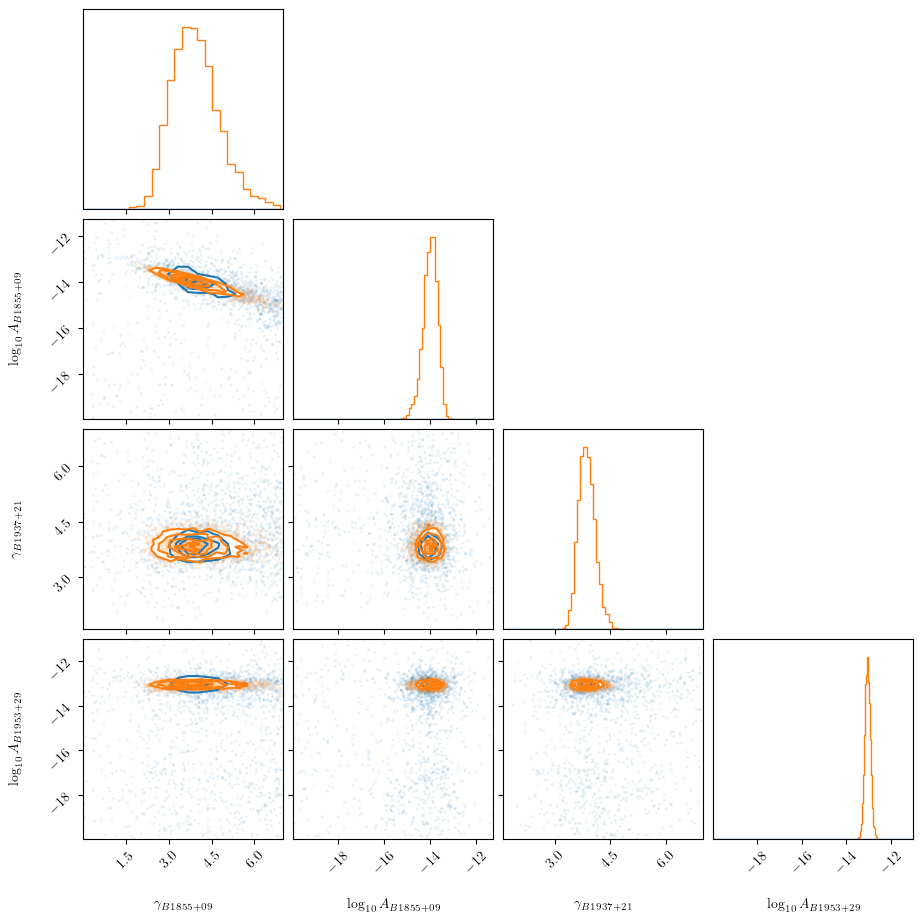

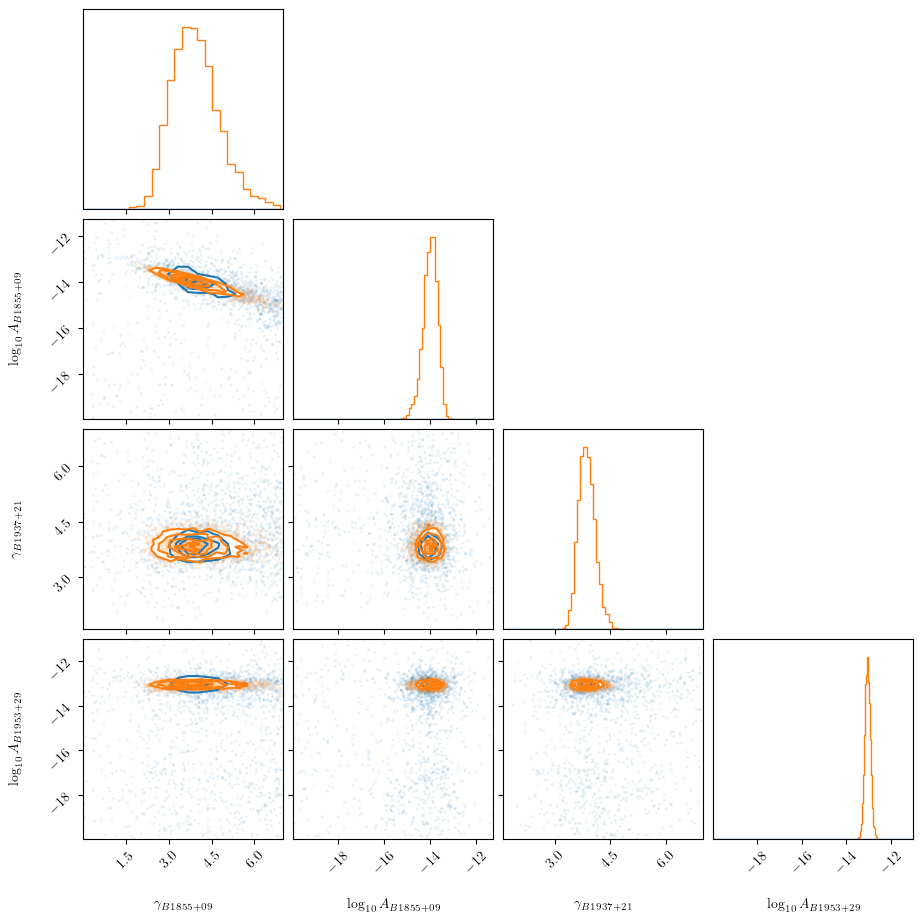

In [30]:
# Get the chain samples from the dict
import corner
from torch import norm
fig = corner.corner(samples_gpry["X"], labels=[latex_labels[n] for n in bridge.sampled_names], color='C0', label='GPry', weights=samples_gpry["w"], normed=True)
corner.corner(samples_nessai["chain"], labels=[latex_labels[n] for n in bridge.sampled_names], color='C1', label='Nessai', fig=fig, normed=True)

In [11]:
fig = bridge.plot_trace(plot_fixed=True)
fig.show()

/Users/jeg/Documents/discovery/discoverysamplers/src/discoverysamplers/nessai_interface.py:604: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/6y/nrh4dqv10xxc55k_v95rl4l00000gn/T/ipykernel_36962/2166721642.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [12]:
fig2 = bridge.plot_corner()
fig2.show()

/var/folders/6y/nrh4dqv10xxc55k_v95rl4l00000gn/T/ipykernel_36962/509014709.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()
